# TTC Delay Forecasting

In [1]:
from config import data_path

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dateutil.parser import parse

import re #for parsing
import time

##import libraries
# from data_load import *

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GRU, Dense, Concatenate, Input, Flatten
import numpy as np


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split

2024-12-05 22:33:01.622973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 22:33:01.638835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 22:33:01.643760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 22:33:01.655404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 22:33:02.651667: W tensorflow/comp

In [2]:
# Defining parsing function
def standardize_time(time_str):
    # Add seconds if missing
    if len(time_str.split(':')) == 2:  # Format is h:m
        time_str += ':00'
    return time_str

def standardize_time_format(time_str):
    try:
        # Parse the time string
        parsed_time = parse(str(time_str)).time()  # Extract only the time
        # Format to HH:MM:SS
        return parsed_time.strftime('%H:%M:%S')
    except Exception as e:
        print(f"Could not parse '{time_str}': {e}")
        return None
    
def standardize_date_format(date_str):
    try:
        # Parse the date string
        parsed_date = parse(str(date_str)) 
        # Format to YYYY-MM-DD
        return parsed_date.strftime('%Y-%m-%d')
    except Exception as e:
        print(f"Could not parse '{date_str}': {e}")
        return None
    
def parse_string(s):
    try:
        s = s.lower()                   # convert to lowercase
        s = s.replace("station", "stn") # replace "station" with "stn"
        s = s.replace("&", "and")       # replace "&" with "and"
        s = s.replace("centre","center") #other spellings
        s = re.sub(r'\bu\b', 'university', s)
        s = s.replace('stn.','stn')
        s = s.replace("st. clair", "st clair")
        s = s.replace("sta", "station")

        return s
    except Exception as e:
        print(f"Could not parse '{s}': {e}")
        return None



#Defining data loading
def loadRawData(vehicle_type="bus",start_year = 2014, end_year = 2015, data_path = data_path):
    """
    vehicle_type = bus, subway, streetcar
    start_year = start of year range
    end_year = end of year range
    targets = targets of dataset
    features = features of dataset
    loads data, based off given parameters
    """
    # print('subfolder path', data_path)
    subfolder_path = os.path.join(data_path, vehicle_type)

    print('subfolder path', subfolder_path)
    if not os.path.isdir(subfolder_path):
            print("error")
            raise ValueError(f"Subfolder '{vehicle_type}' does not exist in {data_path}.") #making sure path is correct

    all_data = pd.DataFrame()

    for filename in os.listdir(subfolder_path):
        
        print("On filename:",filename)

        if (
            filename.endswith(".xlsx") and
            filename.startswith(f"ttc-{vehicle_type}-delay-data") and
            start_year <= int(filename.split("-")[-1].split(".")[0]) <= end_year
        ):
                file_path = os.path.join(subfolder_path, filename)
                sheet_names = pd.ExcelFile(file_path).sheet_names
                for month in sheet_names:
                    data = pd.read_excel(file_path,sheet_name=month)
                    # print(data.columns)
                    # accounting for inconsistent data formatting
                    if 'Report Date' in data.columns:
                        pass  # Column is already named "Date"
                        
                    elif 'Date' in data.columns:
                        # print("Renamed date to report date")
                        data.rename(columns={'Date': 'Report Date'}, inplace=True)

                    if 'Delay' in data.columns:
                        # print("Renamed Delay to Min Delay")
                        data.rename(columns={'Delay': 'Min Delay'}, inplace=True)
                    elif 'Min Delay' in data.columns:
                        pass  # Column is already named Min Delay
                    
                    all_data = pd.concat([all_data, data], ignore_index=True)    
    return all_data

In [3]:
import os
import pandas as pd


#testing to see

def loadRawData_NODIV(vehicle_type="bus", start_year=2014, end_year=2015, data_path=data_path):
    """
    vehicle_type = bus, subway, streetcar
    start_year = start of year range
    end_year = end of year range
    data_path = path to the data folder
    loads data, based off given parameters
    """
    # Define the subfolder path based on the vehicle type
    subfolder_path = os.path.join(data_path, vehicle_type)

    print('subfolder path', subfolder_path)
    if not os.path.isdir(subfolder_path):
        print("error")
        raise ValueError(f"Subfolder '{vehicle_type}' does not exist in {data_path}.")  # Check if path is correct

    all_data = pd.DataFrame()

    for filename in os.listdir(subfolder_path):
        print("On filename:", filename)

        # Only process relevant files based on the filename structure and year range
        if (
            filename.endswith(".xlsx") and
            filename.startswith(f"ttc-{vehicle_type}-delay-data") and
            start_year <= int(filename.split("-")[-1].split(".")[0]) <= end_year
        ):
            file_path = os.path.join(subfolder_path, filename)
            sheet_names = pd.ExcelFile(file_path).sheet_names
            for month in sheet_names:
                data = pd.read_excel(file_path, sheet_name=month)
                
                # Accounting for inconsistent data formatting and renaming columns as necessary
                if 'Report Date' in data.columns:
                    pass  # Column is already named "Report Date"
                elif 'Date' in data.columns:
                    # Rename 'Date' to 'Report Date'
                    data.rename(columns={'Date': 'Report Date'}, inplace=True)

                if 'Delay' in data.columns:
                    # Rename 'Delay' to 'Min Delay'
                    data.rename(columns={'Delay': 'Min Delay'}, inplace=True)
                elif 'Min Delay' in data.columns:
                    pass  # Column is already named "Min Delay"
                
                # Filter out rows where the "incident" column is "Diversion"
                if 'Incident' in data.columns:
                    data = data[data['Incident'] != 'Diversion']

                # Concatenate the processed data
                all_data = pd.concat([all_data, data], ignore_index=True)

    return all_data


In [4]:
#Defining sliding window function

def create_sliding_windows(df, n_steps, n_outputs, target_column):
    """
    Converts a DataFrame into overlapping sliding windows.

    Parameters:
    - df: Input DataFrame with features and target variable.
    - n_steps: Number of time steps in the input sequence.
    - n_outputs: Number of time steps in the output sequence.
    - target_column: Name or index of the target column.

    Returns:
    - X: Numpy array of shape (num_samples, n_steps, num_features)
    - y: Numpy array of shape (num_samples, n_outputs)
    """
    X, y = [], []
    if isinstance(target_column, str):
        target_index = df.columns.get_loc(target_column)  # Get column index
    else:
        target_index = target_column

    data = df.to_numpy()  # Convert to NumPy for efficiency
    for i in range(len(data) - n_steps - n_outputs + 1):
        # Include all columns except the target in X
        X.append(data[i:i + n_steps, :])
        # Use only the target column for y
        y.append(data[i + n_steps:i + n_steps + n_outputs, target_index])
    X = np.array(X)
    y = np.array(y)

    # Exclude the target column from X (optional if the target is among features)
    # X = np.delete(X, target_index, axis=-1)
    return X, y

In [5]:
''' #code to investigate into the direction column / cardinality
description = df['Direction'].describe()
print("Summary Statistics:\n", description)
unique_values_count = df['Direction'].nunique()
print(len(df['Direction']))
print(f"Number of unique values in 'Location': {unique_values_count}")

import matplotlib.pyplot as plt


# Plot the top 10 most common labels
top_labels = df['Direction'].value_counts().head(50)
top_labels_list = top_labels.index.tolist()
print(top_labels_list)
# for label in top_labels_list:
#      print(label)

top_labels.plot(kind='bar', figsize=(10, 5))

# Set title and labels
plt.title('Direction vs Frequency')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
'''
''' #code to investigate the Location column / cardinality:
description = df['Location'].describe()
print("Summary Statistics:\n", description)
unique_values_count = df['Location'].nunique()
print(len(df['Location']))
print(f"Number of unique values in 'Location': {unique_values_count}")

import matplotlib.pyplot as plt


# Plot the top 10 most common labels
top_labels = df['Location'].value_counts().head(1000)
top_labels_list = top_labels.index.tolist()
print(top_labels_list)
# for label in top_labels_list:
#      print(label)

top_labels.plot(kind='bar', figsize=(100, 20))

# Set title and labels
plt.title('Top 500 Most Frequent Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
'''

' #code to investigate the Location column / cardinality:\ndescription = df[\'Location\'].describe()\nprint("Summary Statistics:\n", description)\nunique_values_count = df[\'Location\'].nunique()\nprint(len(df[\'Location\']))\nprint(f"Number of unique values in \'Location\': {unique_values_count}")\n\nimport matplotlib.pyplot as plt\n\n\n# Plot the top 10 most common labels\ntop_labels = df[\'Location\'].value_counts().head(1000)\ntop_labels_list = top_labels.index.tolist()\nprint(top_labels_list)\n# for label in top_labels_list:\n#      print(label)\n\ntop_labels.plot(kind=\'bar\', figsize=(100, 20))\n\n# Set title and labels\nplt.title(\'Top 500 Most Frequent Labels\')\nplt.xlabel(\'Label\')\nplt.ylabel(\'Frequency\')\nplt.grid(axis=\'y\', linestyle=\'--\', alpha=0.7)\n\n# Show the plot\nplt.show()\n'

In [6]:
#getting data
vehicle_type = 'bus'
start_year = 2014 #min
end_year = 2023 #max

#number of outputs: (how many points ahead to forecast)s

targets = ["Min Delay"]
features = ["Report Date", "Time","Direction", "Location", "Route"]

print("Loading data")
df_raw = loadRawData_NODIV(vehicle_type=vehicle_type,start_year=start_year,end_year=end_year)

print("Finished loading data")

Loading data
subfolder path /media/jadenh/SSD2/TTC_DATA/bus
On filename: ttc-bus-delay-data-2014.xlsx
On filename: ttc-bus-delay-data-2015.xlsx
On filename: ttc-bus-delay-data-2016.xlsx
On filename: ttc-bus-delay-data-2017.xlsx
On filename: ttc-bus-delay-data-2018.xlsx
On filename: ttc-bus-delay-data-2019.xlsx
On filename: ttc-bus-delay-data-2020.xlsx
On filename: ttc-bus-delay-data-2021.xlsx
On filename: ttc-bus-delay-data-2022.xlsx
On filename: ttc-bus-delay-data-2023.xlsx
On filename: ttc-bus-delay-data-2024.xlsx
Finished loading data


In [41]:
## Defining parameters:
df = df_raw.copy()

n_outputs = 1 #forecasting the next delay
n_steps = 5 # how many points to use # assuming about 4 delays per hour * 24 hours / day ~ 100 points of data
## Processing Data

#first, sort index
df = df.sort_index() 

print("Using features:\n",features,"\nTargets:",targets)

df = df[targets+features] #only using necessary data
df.dropna(axis=0, how='any', inplace=True) #drops empty rows where any are null  
print("target + features + dropped empty:\n",df.head())


# applying parsing functions to the time and date (due to different formats)
df['Time'] = df['Time'].apply(standardize_time_format)
df['Report Date'] = df['Report Date'].apply(standardize_date_format)
# df['Location_encode'] = df['Location'].apply(parse_string) #may not need if we use embedding ?

df['Datetime'] = pd.to_datetime((df['Report Date'] + ' ' + df['Time']),format='%Y-%m-%d %H:%M:%S') #combining into one column
df.drop(columns = ['Time','Report Date'], inplace = True)

# preprocessing the DIRECTION to make consistent 4 + 1 directions 
valid_directions = ['n','s','e','w','b'] #should only have n,e,s,w, b - both ways
df['Direction'] = df['Direction'].str[0].str.lower()
df['Direction'] = df['Direction'].apply(lambda x: x if x in valid_directions else 'unknown')

df['Location'] = df['Location'].apply(parse_string)

df['Route'] = df['Route'].astype(str)
## one hot encoding 
# the only one hot encoded feature will be: 'Direction', as determined by the data exploration

# df['Direction'] = df['Direction'].astype(str) #formatting necessary????

one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = one_hot_encoder.fit_transform(df[['Direction']])

one_hot_encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(['Direction']))

df = pd.concat([df, one_hot_encoded_df], axis=1)
df.drop(df[['Direction']], axis=1, inplace=True) #removing unecessary columns


# defining encoders for embedding
location_encoder = LabelEncoder()
route_encoder = LabelEncoder()

## Using label encodings and embeddings: #
df['Location_encoded'] = location_encoder.fit_transform(df['Location'])
df['Route_encoded'] = route_encoder.fit_transform(df['Route'])

df = df.drop('Location',axis=1)
df = df.drop('Route',axis=1)

location_vocab_size = len(location_encoder.classes_)  # Number of unique locations
route_vocab_size = len(route_encoder.classes_)  # Number of unique routes


df.dropna(axis=0, how='any', inplace=True) #drops empty rows where any are null  
df.set_index('Datetime',inplace=True)
# Extract year, month, day, hour, and minute from the Datetime index
df['year'] = df.index.year.astype(int)
df['month'] = df.index.month.astype(int)
df['day'] = df.index.day.astype(int)
df['hour'] = df.index.hour.astype(int)
df['minute'] = df.index.minute.astype(int)



# Add cyclical features for time components
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  # Assuming 31 days max
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# Handling year as cyclical
df['day_of_year'] = df.index.dayofyear  # The day of the year
df['year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)  # Using 365.25 for leap years
df['year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

df.drop(columns=['month','day','hour','minute', 'day_of_year'], inplace=True)


# statistics = pd.DataFrame({
#     'max': df[['year', 'month', 'day', 'hour', 'minute']].max(),
#     'min': df[['year', 'month', 'day', 'hour', 'minute']].min(),
#     'std': df[['year', 'month', 'day', 'hour', 'minute']].std()
# })

# print(statistics)
    
scaler = RobustScaler() #because we want model to be robust to outliars of which there are a couple
# scaler = StandardScaler() #standard because we expect standard deviation
# scaler = MinMaxScaler() #min max because ...

df[['Min Delay']] = scaler.fit_transform(df[['Min Delay']])
df.dropna(axis=0, how='any', inplace=True)

# df = df.sort_index() - shouldn't need to sort again

print(df.head())

#split dataframe into embedded encoded features, and regular features (for sliding window)

# embed_features = ['Location_encoded', 'Route_encoded']
# df_embed = df[embed_features]
# df = df.drop(embed_features,axis=1)

delay_stats = df['Min Delay'].describe()
print("Statistics of the min delay:",delay_stats)


# split the dataframes into training and testing dataframes to avoid data leakage
#splitting data
test_size = 0.2
split_index = int(len(df) * (1 - test_size))

df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:] 

test_size = 0.2
split_index = int(len(df) * (1 - test_size))


X_train, y_train = create_sliding_windows(df_train,n_steps,n_outputs,target_column=targets[0])
X_test, y_test = create_sliding_windows(df_test,n_steps,n_outputs,target_column=targets[0])

print("Finished loading data")

print("x train shape:", X_train.shape)
print("x test shape:", X_test.shape)
print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)

Using features:
 ['Report Date', 'Time', 'Direction', 'Location', 'Route'] 
Targets: ['Min Delay']
target + features + dropped empty:
    Min Delay Report Date      Time Direction              Location  Route
0       10.0  2014-01-01  00:23:00         E    York Mills station   95.0
1       33.0  2014-01-01  00:55:00       b/w  Entire run for route  102.0
2       10.0  2014-01-01  01:28:00        WB   lawrence and Warden   54.0
3       18.0  2014-01-01  01:30:00         N       Kipling Station  112.0
4       10.0  2014-01-01  01:37:00         n      VP and Ellesmere   24.0
                     Min Delay  Direction_e  Direction_n  Direction_s  \
Datetime                                                                
2014-01-01 00:23:00      0.000          1.0          0.0          0.0   
2014-01-01 00:55:00      2.875          0.0          0.0          0.0   
2014-01-01 01:28:00      0.000          0.0          0.0          0.0   
2014-01-01 01:30:00      1.000          0.0          1.0

In [14]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Define a function that creates and compiles the LSTM model
def create_lstm_model(hp):
    # Define the input shapes for time features, location, and route
    n_steps = X_train.shape[1]  # Number of time steps in the sliding window
    n_features = X_train.shape[2] - 2  # Number of features for time inputs

    # Input layers
    features_input = layers.Input(shape=(n_steps, n_features), name='features_input')
    location_input = layers.Input(shape=(n_steps, 1), name='Location_input')
    route_input = layers.Input(shape=(n_steps, 1), name='Route_input')

    # LSTM layers
    lstm_out = layers.LSTM(
        hp.Int('num_neurons_1', min_value=20, max_value=160, step=20), 
        activation='relu', 
        return_sequences=True,
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    )(features_input)

    lstm_out = layers.BatchNormalization()(lstm_out)
    lstm_out = layers.Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.8, step=0.05))(lstm_out)

    lstm_out = layers.LSTM(
        hp.Int('num_neurons_2', min_value=20, max_value=100, step=20),
        activation='relu', 
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    )(lstm_out)
    lstm_out = layers.BatchNormalization()(lstm_out)
    lstm_out = layers.Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.8, step=0.1))(lstm_out)

    # Embedding layers for categorical features (location and route)
    location_embedded = layers.Embedding(input_dim=location_vocab_size, output_dim=hp.Int('location_embedding_dim', min_value=10, max_value=40, step=10))(location_input)
    route_embedded = layers.Embedding(input_dim=route_vocab_size, output_dim=hp.Int('route_embedding_dim', min_value=5, max_value=20, step=5))(route_input)

    location_embedded = layers.Flatten()(location_embedded)
    route_embedded = layers.Flatten()(route_embedded)

    # Concatenate the LSTM output with the embedded categorical features
    x = layers.Concatenate()([lstm_out, location_embedded, route_embedded])

    # Dense layer for final output
    x = layers.Dense(hp.Int('num_neurons_3', min_value=20, max_value=120, step=20), activation='relu')(x)
    # x = layers.BatchNormalization()(x)

    output = layers.Dense(n_outputs)(x)

    # Compile the model with an Adam optimizer, adding gradient clipping
    optimizer = Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-8, max_value=1e-4, sampling='LOG'),
        clipvalue=1.0  # Gradient clipping by value, set to 1.0 or any other value that suits your needs
        # Alternatively, you can use clipnorm:
        # clipnorm=1.0  # Gradient clipping by norm
    )
    
    model = models.Model(inputs=[features_input, location_input, route_input], outputs=output)
    model.compile(optimizer=optimizer, metrics=['mse', 'mae'], loss='mae')

    return model

# Define the ReduceLROnPlateau callback
lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by half when plateau is detected
    patience=1,  # Wait for 2 epochs before reducing the learning rate
    min_lr=1e-8  # Minimum learning rate
)

# Define the Hyperband Tuner
lstm_tuner = kt.Hyperband(
    create_lstm_model,
    objective='val_loss',
    max_epochs=25,  # Maximum number of epochs per model
    factor=2,  # Reduction factor for resource allocation
    directory='kt_dir',
    project_name='traffic_delay_lstm_hpo_hyperband_sincos'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Splitting the data into non-embedded features and embedded features
X_train_regular = np.concatenate((X_train[:, :, :6], X_train[:, :, 8:]), axis=2)
X_train_location = X_train[:, :, 6:7]
X_train_route = X_train[:, :, 7:8]

# Define batch_size as a hyperparameter in the search space
batch_size = 256
# Perform the search with the ReduceLROnPlateau callback
lstm_tuner.search(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=25,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping, lr_on_plateau],  # Include both early stopping and ReduceLROnPlateau
    shuffle=False
)

# Retrieve the best hyperparameters
lstm_best_hyperparameters = lstm_tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters:", lstm_best_hyperparameters)


Trial 7 Complete [00h 00m 37s]
val_loss: 0.8304650187492371

Best val_loss So Far: 0.8304650187492371
Total elapsed time: 00h 04m 33s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
120               |80                |num_neurons_1
0.00020286        |0.00028008        |l2_penalty
0.55              |0.8               |dropout_rate_1
60                |60                |num_neurons_2
10                |20                |location_embedding_dim
10                |10                |route_embedding_dim
100               |40                |num_neurons_3
3.4811e-08        |1.5037e-05        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
1253/1320 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9865 - mae: 0.9474 - mse: 2.2586

KeyboardInterrupt: 

In [15]:
# Build and train the best model
lstm_best_hyperparameters = lstm_tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters:", lstm_best_hyperparameters.values)
lstm_model = lstm_tuner.hypermodel.build(lstm_best_hyperparameters)


lstm_history = lstm_model.fit(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping,lr_on_plateau],
    shuffle=False
)

Best Hyperparameters: {'num_neurons_1': 80, 'l2_penalty': 0.00028007529232923885, 'dropout_rate_1': 0.8, 'num_neurons_2': 60, 'location_embedding_dim': 20, 'route_embedding_dim': 10, 'num_neurons_3': 40, 'learning_rate': 1.503666933887865e-05, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}
Epoch 1/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 1.1456 - mae: 1.1060 - mse: 2.8304 - val_loss: 0.8275 - val_mae: 0.7947 - val_mse: 3.5010 - learning_rate: 1.5037e-05
Epoch 2/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.8492 - mae: 0.8182 - mse: 1.9996 - val_loss: 0.8284 - val_mae: 0.8019 - val_mse: 3.6736 - learning_rate: 1.5037e-05
Epoch 3/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.7841 - mae: 0.7583 - mse: 1.8757 - val_loss: 0.8103 - val_mae: 0.7861 - val_mse: 3.5375 - learning_rate: 7.5183e-06
Epoch 4/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.7751 - mae: 0.7515 - mse: 1.8618 - val_loss: 0.8115 - val_mae

(422184, 10, 17) (422184, 10, 1) (422184, 10, 1) (422184, 1)
(105539, 10, 17) (105539, 10, 1) (105539, 10, 1) (105539, 1)
13194/13194 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 0.6940 - mae: 0.6751 - mse: 1.8641
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 1.0780 - mae: 1.0591 - mse: 15.2495
Training Metrics:
loss: 0.7236
mae: 0.7047
mse: 2.5925

Testing Metrics:
loss: 1.0302
mae: 1.0113
mse: 12.7652


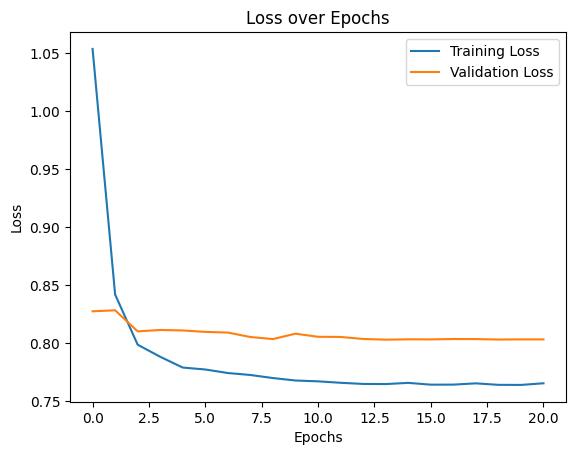

In [16]:
def test_model(model,X_train_regular, X_train_location, X_train_route, X_test_regular, X_test_location, X_test_route,y_train,y_test,history):
    #Testing model:
    # getting predictions of model:

    print(X_train_regular.shape, X_train_location.shape, X_train_route.shape,y_train.shape)
    print(X_test_regular.shape, X_test_location.shape, X_test_route.shape,y_test.shape)

    train_metrics = model.evaluate(
        [X_train_regular, X_train_location, X_train_route], 
        y_train, 
        verbose=1, 
        return_dict=True
    )
    test_metrics = model.evaluate(
        [X_test_regular, X_test_location, X_test_route], 
        y_test, 
        verbose=1, 
        return_dict=True
    )

    # Print the evaluation results
    print("Training Metrics:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nTesting Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plot loss over epochs
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


X_test_regular = np.concatenate((X_test[:, :, :6], X_test[:, :, 8:]), axis=2)
X_test_location = X_test[:, :, 6:7]
X_test_route =X_test[:, :, 7:8]


test_model(lstm_model,X_train_regular, X_train_location, X_train_route, X_test_regular, X_test_location, X_test_route, y_train,y_test,lstm_history)


In [136]:
import numpy as np
steps = 10
# Function to forecast the next 4 delays
def forecast_next_delays(model, X_test_regular, X_test_location, X_test_route, scaler, steps):
    # Get the last 'n_steps' of the test data for each input
    last_data_regular = X_test_regular[-1:, :, :]  # Last regular data (features)
    last_data_location = X_test_location[-1:, :, :]  # Last location data
    last_data_route = X_test_route[-1:, :, :]  # Last route data

    # List to store predicted delays
    predictions = []

    # Predict the next 'steps' delays
    for step in range(steps):
        # Predict the next delay
        predicted_delay = model.predict([last_data_regular, last_data_location, last_data_route],verbose=0)

        # Ensure predicted_delay is a scalar by extracting the appropriate value
        predicted_delay = predicted_delay[0, 0]  # Assuming shape (batch_size, 1) for a single prediction
        
        # Append the predicted value to the predictions list
        predictions.append(predicted_delay)
        
        # Prepare the input for the next prediction:
        # Roll the data to drop the oldest time step and add the predicted value
        last_data_regular = np.roll(last_data_regular, shift=-1, axis=1)
        last_data_location = np.roll(last_data_location, shift=-1, axis=1)
        last_data_route = np.roll(last_data_route, shift=-1, axis=1)

        # Add the predicted delay to each of the inputs for the next time step
        last_data_regular[0, -1, -1] = predicted_delay  # Add to regular data
        last_data_location[0, -1, -1] = predicted_delay  # Add to location data
        last_data_route[0, -1, -1] = predicted_delay  # Add to route data

    # Unscale the predicted delays using the scaler
    # predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()

    # return predictions_unscaled
    return predictions

# Example of how to use the function to forecast the next 4 delays
# Assuming you have your trained model `lstm_model` and the scaler for the delays (e.g., MinMaxScaler)
predicted_delays = forecast_next_delays(lstm_model, X_test_regular, X_test_location, X_test_route, scaler, steps)  # four steps

print("Predicted Delays for the next 4 time steps (unscaled):", predicted_delays)


Predicted Delays for the next 4 time steps (unscaled): [0.0061130077, 0.054378197, -0.014541447, 0.11605771, -0.068369135, 9.400881, -0.07051766, 0.21886826, 0.07800908, 0.115333885]


Predicting for: 250  steps
Step 1/250:
Step 11/250:
Step 21/250:
Step 31/250:
Step 41/250:
Step 51/250:
Step 61/250:
Step 71/250:
Step 81/250:
Step 91/250:
Step 101/250:
Step 111/250:
Step 121/250:
Step 131/250:
Step 141/250:
Step 151/250:
Step 161/250:
Step 171/250:
Step 181/250:
Step 191/250:
Step 201/250:
Step 211/250:
Step 221/250:
Step 231/250:
Step 241/250:
Step 1/250:
Step 11/250:
Step 21/250:
Step 31/250:
Step 41/250:
Step 51/250:
Step 61/250:
Step 71/250:
Step 81/250:
Step 91/250:
Step 101/250:
Step 111/250:
Step 121/250:
Step 131/250:
Step 141/250:
Step 151/250:
Step 161/250:
Step 171/250:
Step 181/250:
Step 191/250:
Step 201/250:
Step 211/250:
Step 221/250:
Step 231/250:
Step 241/250:
Plotting predictions vs real delays...
Reversing cyclical features for datetime...
Generated datetime series of length 250.


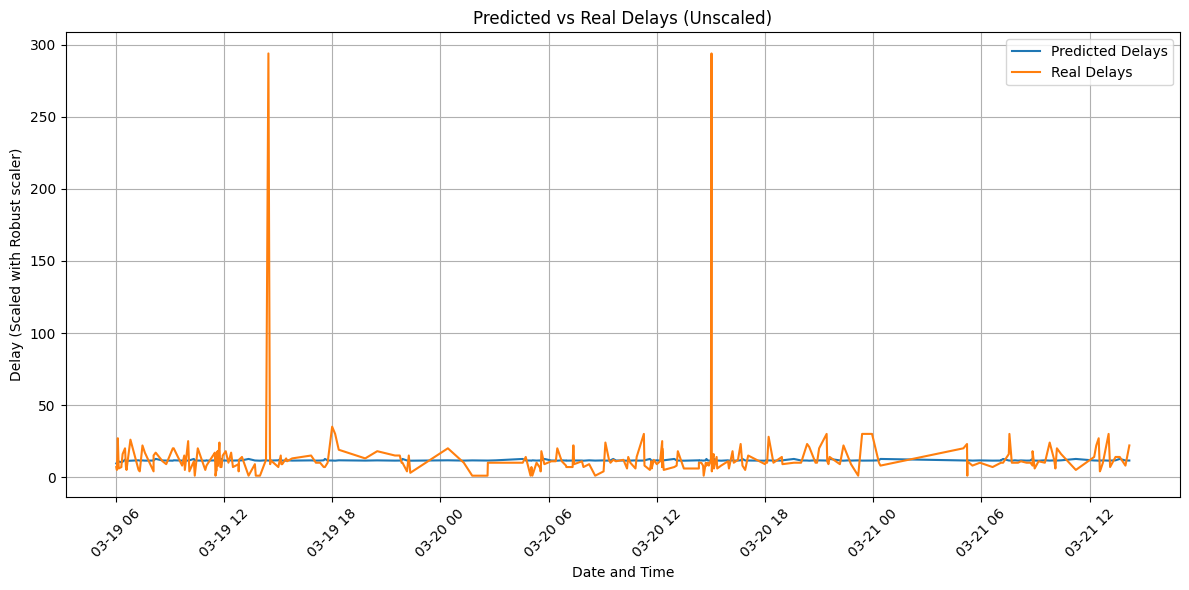

Reversing cyclical features for datetime...
Generated datetime series of length 250.


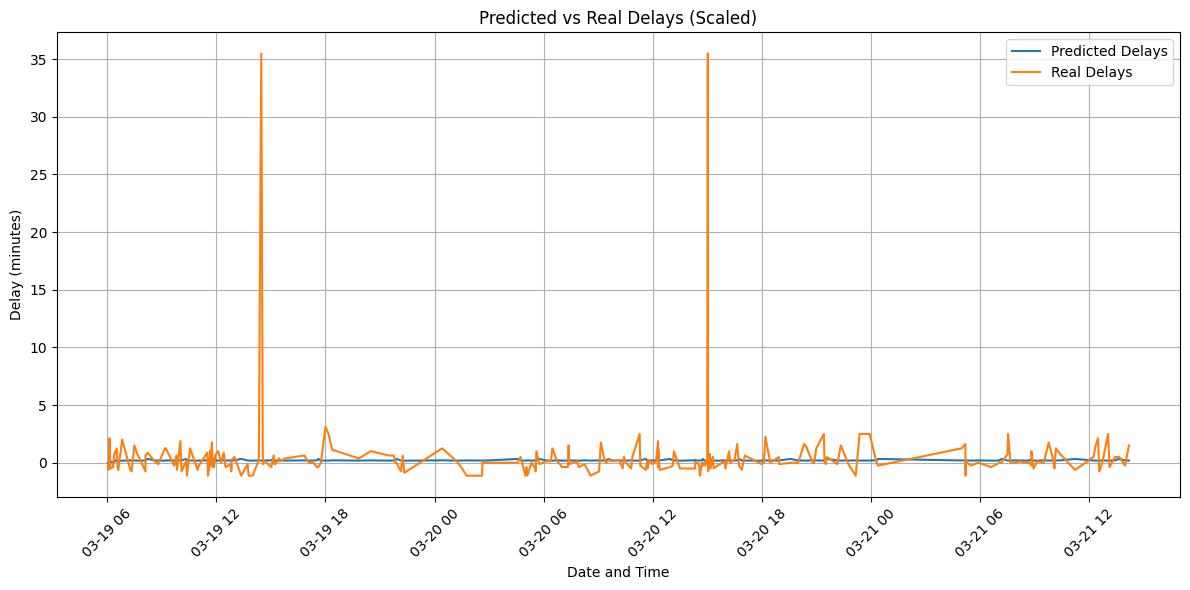

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to forecast delays iteratively
def forecast_next_delays(model, X_test_regular, X_test_location, X_test_route, scaler, steps,unscale = True):
    """
    Predicts the next `steps` delays using the given model and test data.
    """
    # Initialize with the last timestep
    last_data_regular = X_test_regular[-1:, :, :]  # Last timestep for regular features
    last_data_location = X_test_location[-1:, :, :]  # Last timestep for location features
    last_data_route = X_test_route[-1:, :, :]  # Last timestep for route features

    predictions = []  # Store predicted delays

    for step in range(steps):
        if step % 10 == 0:
            print(f"Step {step + 1}/{steps}:")
        # print(f"  Last data regular (shape {last_data_regular.shape}):", last_data_regular)
        # print(f"  Last data location (shape {last_data_location.shape}):", last_data_location)
        # print(f"  Last data route (shape {last_data_route.shape}):", last_data_route)

        # Predict next delay
        predicted_delay = model.predict([last_data_regular, last_data_location, last_data_route], verbose=0)
        predicted_delay = predicted_delay[0, 0]  # Extract scalar value
        # print(f"  Predicted delay: {predicted_delay}")

        predictions.append(predicted_delay)  # Store the prediction

        # Prepare for next iteration by sliding the window
        last_data_regular = np.roll(last_data_regular, shift=-1, axis=1)
        last_data_location = np.roll(last_data_location, shift=-1, axis=1)
        last_data_route = np.roll(last_data_route, shift=-1, axis=1)

        # Update the last positions with the new predicted delay
        last_data_regular[0, -1, -1] = predicted_delay
        last_data_location[0, -1, -1] = predicted_delay
        last_data_route[0, -1, -1] = predicted_delay

    # Unscale the predictions if desired
    if unscale:
        predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()
        # print("Unscaled predictions:", predictions_unscaled)
        return predictions_unscaled
    else:
        return predictions


# Function to reverse cyclical features into datetime
def reverse_cyclical(cyclical_features):
    """
    Converts cyclical features (sin, cos) into datetime components.
    """

    year = cyclical_features[:,0]
    month_sin, month_cos = cyclical_features[:, 1], cyclical_features[:, 2]
    day_sin, day_cos = cyclical_features[:, 3], cyclical_features[:, 4]
    hour_sin, hour_cos = cyclical_features[:, 7], cyclical_features[:, 8]
    minute_sin, minute_cos = cyclical_features[:, 9], cyclical_features[:, 10]

    # Recover datetime components
    month = np.arctan2(month_sin, month_cos) * 12 / (2 * np.pi)
    month = month.round().astype(int)
    month[month < 0] += 12  # Adjust negative values for month

    day = np.arctan2(day_sin, day_cos) * 31 / (2 * np.pi)
    day = day.round().astype(int)
    day[day < 0] += 31  # Adjust negative values for day

    hour = np.arctan2(hour_sin, hour_cos) * 24 / (2 * np.pi)
    hour = hour.round().astype(int)
    hour[hour < 0] += 24  # Adjust negative values for hour

    minute = np.arctan2(minute_sin, minute_cos) * 60 / (2 * np.pi)
    minute = minute.round().astype(int)
    minute[minute < 0] += 60  # Adjust negative values for minute


    # Ensure bounds
    # print(f"year: {year}")
    # print(f"month: {month}")
    # print(f"day: {day}")
    # print(f"hour: {hour}")
    # print(f"minute: {minute}")


    # month = np.clip(month, 1, 12)
    # day = np.clip(day, 1, 31)
    # hour = np.clip(hour, 0, 23)
    # minute = np.clip(minute, 0, 59)

    # print(f"year: {year}")
    # print(f"month: {month}")
    # print(f"day: {day}")
    # print(f"hour: {hour}")
    # print(f"minute: {minute}")

    # Generate datetime series
    datetime_series = pd.to_datetime({
        'year': year,
        'month': month,
        'day': day,
        'hour': hour,
        'minute': minute
    })

    print(f"Generated datetime series of length {len(datetime_series)}.")
    return datetime_series

# Function to plot predictions against real delays
def plot_predictions_vs_real(predicted_delays, real_delays, cyclical_features, n_steps, title, xlabel, ylabel):
    """
    Plots predicted delays against real delays, using reversed cyclical features as timestamps.
    """
    # Validate inputs
    if len(predicted_delays) != len(real_delays):
        raise ValueError("Predicted delays and real delays must have the same length.")

    print("Reversing cyclical features for datetime...")
    datetime_series = reverse_cyclical(cyclical_features)

    # Plot predicted vs real delays
    plt.figure(figsize=(12, 6))
    plt.plot(datetime_series, predicted_delays, label='Predicted Delays')#, marker='o')
    plt.plot(datetime_series, real_delays, label='Real Delays')#, marker='x')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# pred_steps = len(X_test)
pred_steps = 250
print("Predicting for:",pred_steps," steps")

# Forecast the next delays
predicted_delays_unscaled = forecast_next_delays(
    model=lstm_model,
    X_test_regular=X_train_regular,
    X_test_location=X_train_location,
    X_test_route=X_train_route,
    scaler=scaler,
    steps=pred_steps,
    unscale=True,
)

predicted_delays = forecast_next_delays(
    model=lstm_model,
    X_test_regular=X_train_regular,
    X_test_location=X_train_location,
    X_test_route=X_train_route,
    scaler=scaler,
    steps=pred_steps,
    unscale=False,
)

# Extract cyclical features for the last steps
cyclical_features = X_test[:pred_steps, 0, 8:19]

# print(df_test.head(pred_steps))

# Get actual delays for comparison
real_delays = y_test[:pred_steps]
# print("Real delays:",real_delays)
real_delays_unscaled = scaler.inverse_transform(np.array(real_delays).reshape(-1, 1)).squeeze()

print("Plotting predictions vs real delays...")
plot_predictions_vs_real(predicted_delays_unscaled, #unscaled (in minutes)
                         real_delays_unscaled,
                         cyclical_features,
                         pred_steps,
                         xlabel = 'Date and Time',
                         ylabel = 'Delay (Scaled with Robust scaler)',
                         title = 'Predicted vs Real Delays (Unscaled)')

plot_predictions_vs_real(predicted_delays,
                         real_delays,
                         cyclical_features,
                         pred_steps,
                         xlabel = 'Date and Time',
                         ylabel = 'Delay (minutes)',
                         title = 'Predicted vs Real Delays (Scaled)') #scaled


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to reverse cyclical features to get the original values
def reverse_cyclical(cyclical_features,n_steps):
    # Extracting the cyclical features: year_sin, year_cos, month_sin, month_cos, day_sin, day_cos, hour_sin, hour_cos, minute_sin, minute_cos
    # print(len(cyclical_features))
    year = cyclical_features[:n_steps, 0]
    month_sin = cyclical_features[:n_steps, 1]
    month_cos = cyclical_features[:n_steps, 2]
    day_sin = cyclical_features[:n_steps, 3]
    day_cos = cyclical_features[:n_steps, 4]
    hour_sin = cyclical_features[:n_steps, 7]
    hour_cos = cyclical_features[:n_steps, 8]
    minute_sin = cyclical_features[:n_steps, 9]
    minute_cos = cyclical_features[:n_steps, 10]

    # Recover original values using the inverse of the cyclical transformation
    # For year, month, day, hour, minute use arctan2 for correct angle reversal

    # Month (1 to 12)
    month = np.arctan2(month_sin, month_cos) * 12 / (2 * np.pi) 
    month = np.round(month).astype(int)

    # Day (1 to 31)
    day = np.arctan2(day_sin, day_cos) * 31 / (2 * np.pi)
    day = np.round(day).astype(int)+31

    # Hour (0 to 23)
    print("hour sin an cos \n",hour_sin,hour_cos)
    hour = np.arctan2(hour_sin, hour_cos) * 24 / (2 * np.pi)
    hour = np.round(hour).astype(int)

    # Minute (0 to 59)
    
    minute = (np.arctan2(minute_sin, minute_cos) * 60 / (2 * np.pi) + 60)%60
    print("min sin and cos\n",minute_sin,minute_cos)
    minute = np.round(minute).astype(int)

    print(year,month,day,hour,minute)
    # Now create the datetime series using these reversed values
    datetime_series = pd.to_datetime({
        'year': year,
        'month': month,
        'day': day,
        'hour': hour,
        'minute': minute
    })
    
    print(f"Length of datetime_series: {len(datetime_series)}")

    return datetime_series

# Function to plot predicted delays against real delays with timestamps
def plot_predictions_vs_real(predicted_delays, real_delays, cyclical_features, n_steps):
    # Ensure that predicted and real delays are of the same length

    print(len(predicted_delays),len(real_delays))
    if len(predicted_delays) != len(real_delays):
        raise ValueError("Predicted delays and real delays must have the same length.")

    # Generate the time series for both predicted and real delays
    datetime_series = reverse_cyclical(cyclical_features,n_steps = n_steps)

    # Plotting the predicted vs real delays
    plt.figure(figsize=(10, 6))
    plt.plot(datetime_series, predicted_delays, label='Predicted Delays', marker='o')
    plt.plot(datetime_series, real_delays, label='Real Delays', marker='x')

    # Adding labels and title
    plt.xlabel('DateTime')
    plt.ylabel('Delay')
    plt.title('Predicted vs Real Delays')
    plt.legend()

    # Show the plot
    plt.xticks(rotation=45)
    plt.show()


# Example of using the functions
pred_steps = 4  # Number of steps you want to predict

print(df_train.tail(pred_steps+n_steps))

# Get the last 4 delays from the train set for comparison
# print(y_train.shape)
real_delays = y_train[-pred_steps:]  # The last 4 values of your training set
unscaled_real_delays = scaler.inverse_transform(np.array(real_delays).reshape(-1, 1)).squeeze()


print("real delays",real_delays)
# Predict the next 4 delays using your forecast function
predicted_delays = forecast_next_delays(lstm_model, X_train_regular, X_train_location, X_train_route, scaler, pred_steps)
# print(predicted_delays.shape)

# Extract the cyclical features for these last 4 steps (columns 9 to 19)
# print(X_train[-pred_steps-n_steps:, 0, 8:19].shape)
cyclical_features = X_train[-n_steps-pred_steps:, 0, 8:19]  # Adjust this to grab the cyclical features from columns 9 to 19

# Plot the predicted delays against the real delays with timestamps
# plot_predictions_vs_real(predicted_delays, unscaled_real_delays, cyclical_features)
plot_predictions_vs_real(predicted_delays, real_delays, cyclical_features, pred_steps)

In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Define a function that creates and compiles the GRU model
def create_gru_model(hp):
    # Define the input shapes for time features, location, and route
    n_steps = X_train.shape[1]  # Number of time steps in the sliding window
    n_features = X_train.shape[2] - 2  # Number of features for time inputs

    # Input layers
    features_input = layers.Input(shape=(n_steps, n_features), name='features_input')
    location_input = layers.Input(shape=(n_steps, 1), name='Location_input')
    route_input = layers.Input(shape=(n_steps, 1), name='Route_input')

    # GRU layers
    gru_out = layers.GRU(
        hp.Int('num_neurons_1', min_value=64, max_value=256, step=64), 
        activation='relu', 
        return_sequences=True,
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    )(features_input)

    gru_out = layers.BatchNormalization()(gru_out)
    gru_out = layers.Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.8, step=0.05))(gru_out)

    gru_out = layers.GRU(
        hp.Int('num_neurons_2', min_value=32, max_value=128, step=32),
        activation='relu', 
        kernel_regularizer=regularizers.l2(hp.Float('l2_penalty', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    )(gru_out)
    gru_out = layers.BatchNormalization()(gru_out)
    gru_out = layers.Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.8, step=0.05))(gru_out)

    # Embedding layers for categorical features (location and route)
    location_embedded = layers.Embedding(input_dim=location_vocab_size, output_dim=hp.Int('location_embedding_dim', min_value=20, max_value=50, step=10))(location_input)
    route_embedded = layers.Embedding(input_dim=route_vocab_size, output_dim=hp.Int('route_embedding_dim', min_value=5, max_value=20, step=5))(route_input)

    location_embedded = layers.Flatten()(location_embedded)
    route_embedded = layers.Flatten()(route_embedded)

    # Concatenate the GRU output with the embedded categorical features
    x = layers.Concatenate()([gru_out, location_embedded, route_embedded])

    # Dense layer for final output
    x = layers.Dense(hp.Int('num_neurons_3', min_value=32, max_value=128, step=32), activation='relu')(x)
    x = layers.BatchNormalization()(x)

    output = layers.Dense(n_outputs)(x)

    # Compile the model with an Adam optimizer
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-8, max_value=1e-3, sampling='LOG'))
    model = models.Model(inputs=[features_input, location_input, route_input], outputs=output)
    model.compile(optimizer=optimizer, metrics=['mse', 'mae'], loss='mse')

    return model

# Define the ReduceLROnPlateau callback
lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by half when plateau is detected
    patience=2,  # Wait for 2 epochs before reducing the learning rate
    min_lr=1e-8  # Minimum learning rate
)

# Define the Hyperband Tuner
gru_tuner = kt.Hyperband(
    create_gru_model,
    objective='val_loss',
    max_epochs=25,  # Maximum number of epochs per model
    factor=5,  # Reduction factor for resource allocation
    directory='kt_dir',
    project_name='traffic_delay_gru_hpo_hyperband_sincos'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Splitting the data into non-embedded features and embedded features
X_train_regular = np.concatenate((X_train[:, :, :6], X_train[:, :, 8:]), axis=2)
X_train_location = X_train[:, :, 6:7]
X_train_route = X_train[:, :, 7:8]

# Define batch_size as a hyperparameter in the search space
batch_size = 256
# Perform the search with the ReduceLROnPlateau callback
gru_tuner.search(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=25,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping, lr_on_plateau],  # Include both early stopping and ReduceLROnPlateau
    shuffle=False
)

# Retrieve the best hyperparameters
gru_best_hyperparameters = gru_tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters:", gru_best_hyperparameters)


Trial 8 Complete [00h 01m 27s]
val_loss: 1.4644348621368408

Best val_loss So Far: 0.9167370200157166
Total elapsed time: 00h 11m 02s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
24                |104               |num_neurons_1
1.8382e-05        |3.7445e-05        |l2_penalty
0.25              |0.35              |dropout_rate
20                |20                |num_neurons_2
30                |50                |location_embedding_dim
15                |10                |route_embedding_dim
12                |36                |num_neurons_3
3.9714e-08        |6.6053e-05        |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
407/698 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 1.1471 - mae: 1.1461 - mse: 2.8549

KeyboardInterrupt: 

In [ ]:
# Build and train the best model
gru_model = gru_tuner.hypermodel.build(gru_best_hyperparameters)


gru_history = gru_model.fit(
    [X_train_regular, X_train_location, X_train_route], 
    y_train,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=False
)

test_model(gru_model,X_train_regular, X_train_location, X_train_route, X_test_regular, X_test_location, X_test_route, y_train,y_test,gru_history)

In [ ]:
#Testing model:
# getting predictions of model:
y_test_pred = rnn_model.predict(X_test)
y_train_pred = rnn_model.predict(X_train)

train_loss, train_mae = rnn_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = rnn_model.evaluate(X_test, y_test, verbose=0)

# # print("Predictions:", y_pred)

# Print model evaluation results
print(f"TensorFlow Evaluation:")
print(f"Training Loss (MSE): {train_loss:.4f}, Training MAE: {train_mae:.4f}")
print(f"Testing Loss (MSE): {test_loss:.4f}, Testing MAE: {test_mae:.4f}")


plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

